A. Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train_house_final.csv')

In [3]:
df.info(show_counts=True)
#No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2832894 entries, 0 to 2832893
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Price                2832894 non-null  int64  
 1   Type                 2832894 non-null  object 
 2   New                  2832894 non-null  object 
 3   Tenure               2832894 non-null  object 
 4   latitude             2832894 non-null  float64
 5   longitude            2832894 non-null  float64
 6   gender_ratio         2832894 non-null  float64
 7   child_ratio          2832894 non-null  float64
 8   elderly_ratio        2832894 non-null  float64
 9   commute_distance     2832894 non-null  float64
 10  Income               2832894 non-null  float64
 11  Eng_Wal              2832894 non-null  object 
 12  London_distance      2832894 non-null  float64
 13  listings_per_capita  2832894 non-null  float64
 14  days_since_first     2832894 non-null  int64  
 15

B. Target price distributions

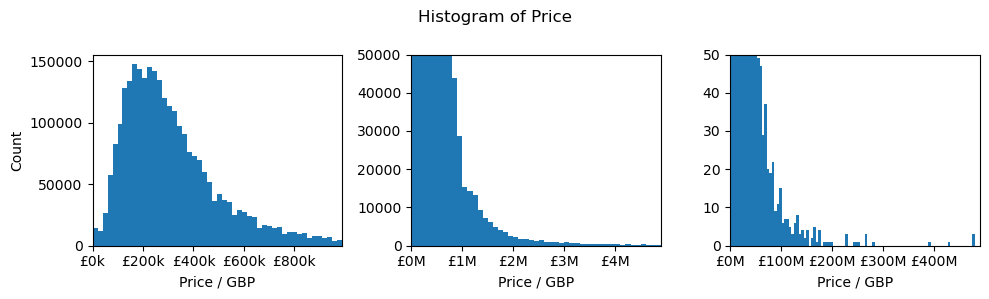

In [4]:
from matplotlib.ticker import FuncFormatter
def thousands_formatter(x, pos):
        return f'£{int(x/1000)}k'
def millions_formatter(x, pos):
        return f'£{int(x/1000000)}M'

fig, axs = plt.subplots(1,3)
fig.set_size_inches(10, 3)

axs[0].set_ylabel('Count')

axs[0].hist(df['Price'], range=[0,990000], bins=50)
axs[0].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
axs[0].set_xlim(0,990000)
axs[0].set_xlabel('Price / GBP')

axs[1].hist(df['Price'], range=[0,5000000], bins=50)
axs[1].xaxis.set_major_formatter(FuncFormatter(millions_formatter))
axs[1].set_xlim(0,4900000)
axs[1].set_ylim(0,50000)
axs[1].set_xlabel('Price / GBP')

axs[2].hist(df['Price'], bins=100)
axs[2].xaxis.set_major_formatter(FuncFormatter(millions_formatter))
axs[2].set_xlim(0,490000000)
axs[2].set_ylim(0,50)
axs[2].set_xlabel('Price / GBP')


plt.suptitle('Histogram of Price')
fig.tight_layout()
plt.savefig('figures//01_price_hist.png', dpi = 600)
plt.show()

#Price is heavily left skewed. Might work better in models if fit in log space
##Some big outliers in the price, 

In [5]:
mean = df['Price'].mean()
std = df['Price'].std()
print(f'mean = {mean:.0f}, std = {std:.0f}')

mean = 405263, std = 1501998


In [6]:
df['Price'].quantile(0.961)
#3.9% over 1million pounds

np.float64(1000000.0)

In [7]:
df['Price'].quantile(0.997)

np.float64(4850000.0)

In [8]:
df['Price'].max()

480000000

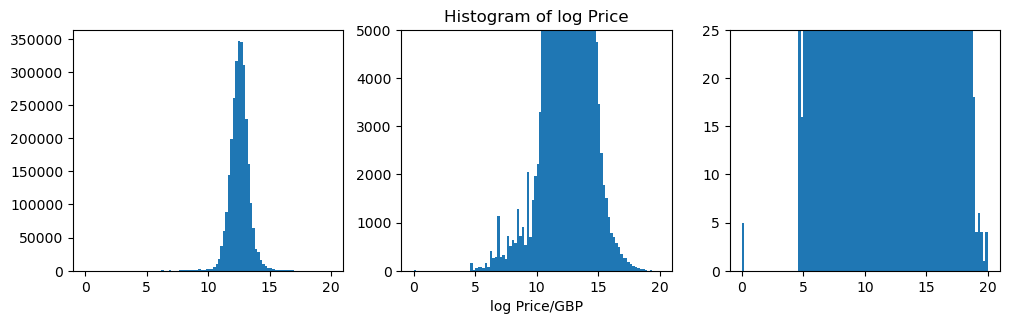

In [9]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(10, 3)
fig.tight_layout()
axs[1].set_title('Histogram of log Price')

axs[0].hist(np.log(df['Price']), bins=100)

axs[1].hist(np.log(df['Price']), bins=100)
axs[1].set_ylim(0,5000)
axs[1].set_xlabel('log Price/GBP')

axs[2].hist(np.log(df['Price']), bins=100)
axs[2].set_ylim(0,25)

plt.show()

#In log space, distribution is much more normal

In [10]:
def fraction_price_less_than(limit):
    """
    returns the fraction of the prices in the data df['Price'] that are less than the arg limit
    prints fraction as well
    """
    fraction = (df['Price']<limit).sum()/df['Price'].count()
    print(f'Fraction of properties less than £{limit} is {fraction:.3f}')
    #return fraction

fraction_price_less_than(1000000) #1 million
fraction_price_less_than(10000000) #10 million

Fraction of properties less than £1000000 is 0.961
Fraction of properties less than £10000000 is 0.999


C. Feature distributions

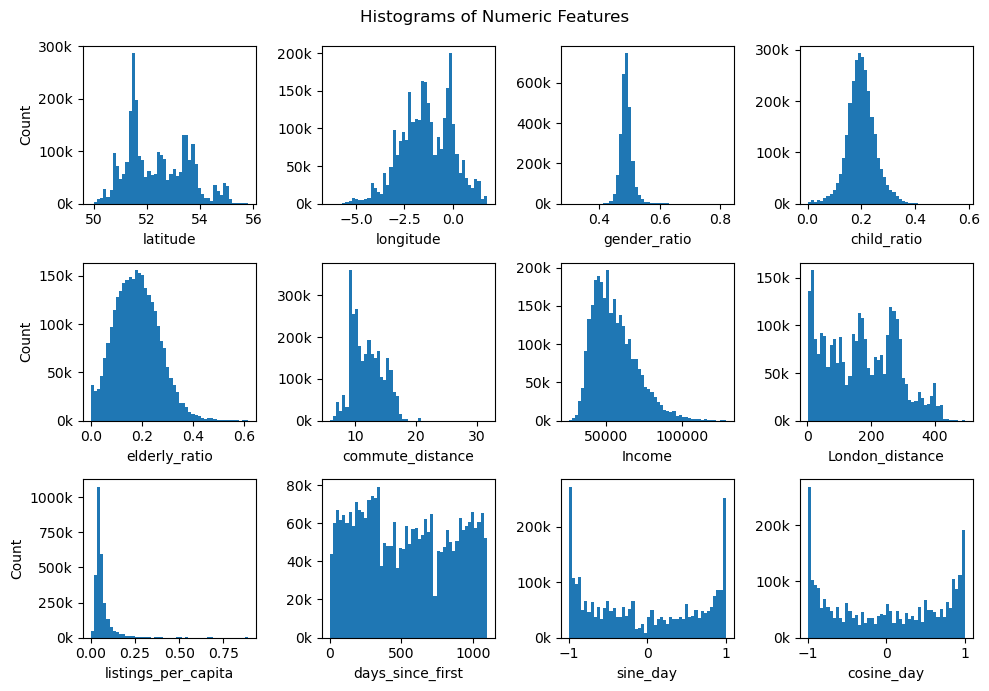

In [11]:
#Hisdograms showing distributions of numeric features

#Numeric features
numeric_feautres = ['latitude',
    'longitude',
    'gender_ratio',
    'child_ratio',
    'elderly_ratio',
    'commute_distance',
    'Income',
    'London_distance',
    'listings_per_capita',
    'days_since_first',
    'sine_day',
    'cosine_day']

def thousands_formatter_no_pound(x, pos):
        return f'{int(x/1000)}k'
def millions_formatter_no_pound(x, pos):
        return f'{int(x/1000000)}M'

fig, axs = plt.subplots(3,4)
fig.set_size_inches(10, 7)

i,j = 0,0

for feature in numeric_feautres:
    axs[i,j].hist(df[feature], bins=50)
    axs[i,j].set_xlabel(feature)
    
    y_limit = axs[i,j].get_ylim()[1]
    if y_limit > 2000000:
        axs[i,j].yaxis.set_major_formatter(FuncFormatter(millions_formatter_no_pound))
    elif y_limit > 2000:
        axs[i,j].yaxis.set_major_formatter(FuncFormatter(thousands_formatter_no_pound))
    
    if j == 3:
        j = 0
        i += 1
    else:
        j += 1

axs[0,0].set_ylabel('Count')
axs[1,0].set_ylabel('Count')
axs[2,0].set_ylabel('Count')

plt.suptitle('Histograms of Numeric Features')
fig.tight_layout()

plt.savefig('figures//02_num_features_hist.png', dpi = 600)
plt.show()


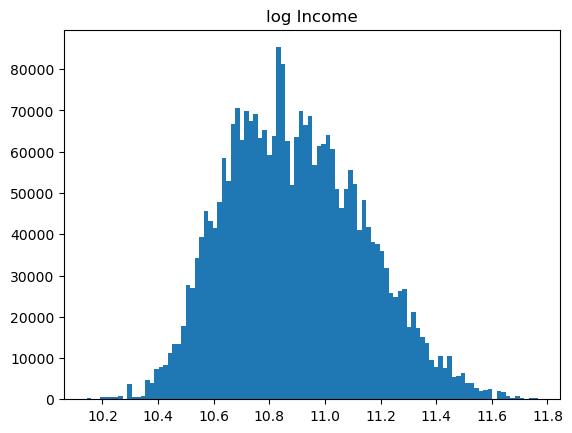

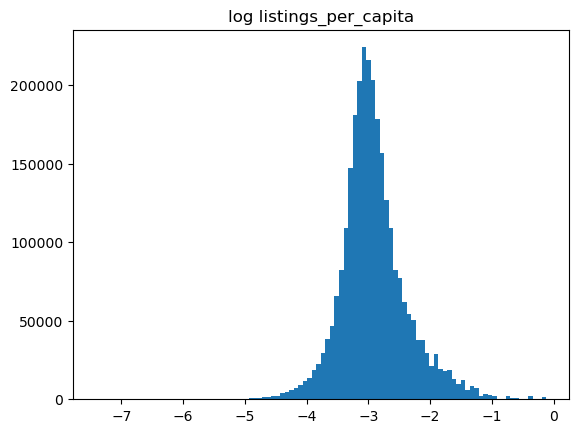

In [12]:
#income and listings per capita are left skewed. How do they look when plotting log values
#Look much more normal
for feature in ['Income', 'listings_per_capita']:
    plt.hist(np.log(df[feature]), bins=100)
    plt.title('log '+feature)
    plt.show()

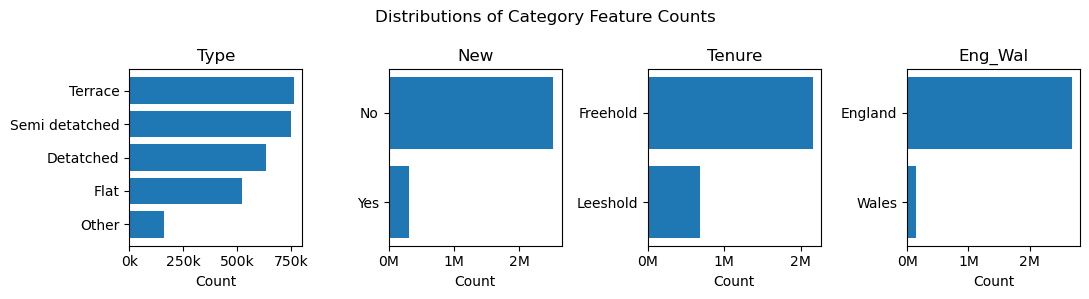

In [16]:
#Categorical features
category_features = [
    'Type',
    'New',
    'Tenure',
    'Eng_Wal']

#Mapping no more desdcriptive category names
type_map = {'T':'Terrace',
            'S':'Semi detatched',
            'D':'Detatched',
            'F':'Flat',
            'O':'Other'}
new_map = {'Y':'Yes',
            'N':'No'}
tenure_map = {'F':'Freehold',
              'L':'Leeshold'}
df2 = df.copy()
df2['Type'] = df2['Type'].map(type_map)
df2['New'] = df2['New'].map(new_map)
df2['Tenure'] = df2['Tenure'].map(tenure_map)

#Plotting figure
fig, axs = plt.subplots(1,4)
fig.set_size_inches(11, 3)

j = 0

for feature in category_features:
    counts = df2[feature].value_counts().sort_values()
    axs[j].barh(counts.index,counts.values)
    axs[j].set_title(feature)
    axs[j].set_xlabel('Count')

    y_limit = axs[j].get_xlim()[1]
    if y_limit > 2000000:
        axs[j].xaxis.set_major_formatter(FuncFormatter(millions_formatter_no_pound))
    elif y_limit > 2000:
        axs[j].xaxis.set_major_formatter(FuncFormatter(thousands_formatter_no_pound))

    j += 1

#axs[0].set_ylabel('Count')

plt.suptitle('Distributions of Category Feature Counts')
fig.tight_layout()

plt.savefig('figures//03_cat_features_bar.png', dpi = 600)
plt.show()

D. Correlation of different features with price

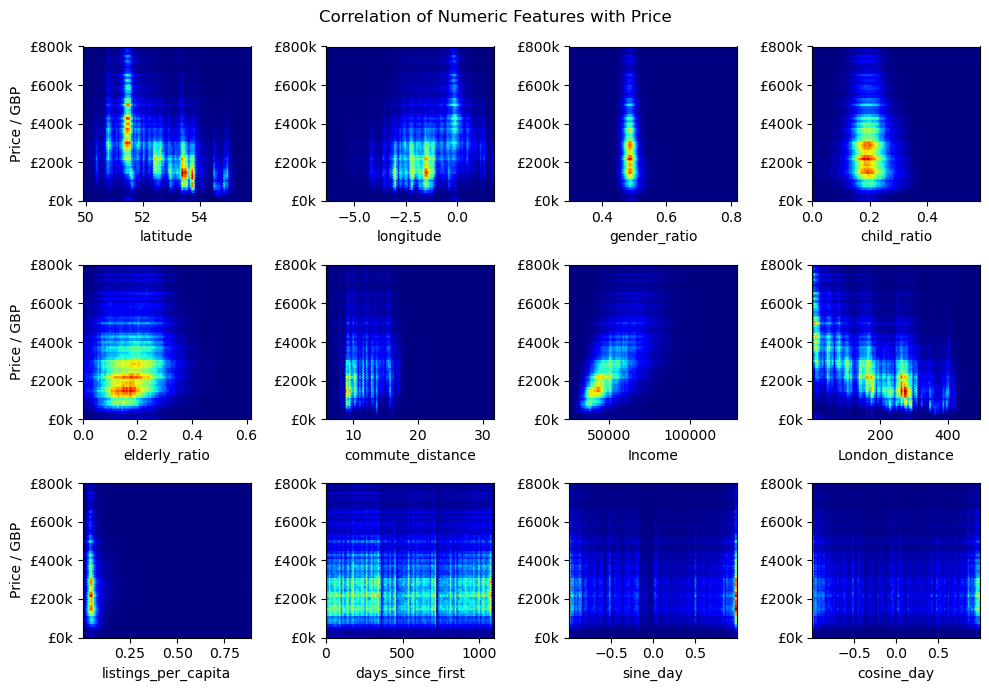

In [30]:
#Plotting correlation as hexbin for numeric features
fig, axs = plt.subplots(3,4)
fig.set_size_inches(10, 7)

i,j = 0,0

for feature in numeric_feautres:
    axs[i,j].hexbin(df[feature], df['Price'], extent=[df[feature].min(),df[feature].max(),0,800000], cmap='jet')
    axs[i,j].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    axs[i,j].set_xlim(df[feature].min(),df[feature].max())
    axs[i,j].set_ylim(0,800000)
    axs[i,j].set_xlabel(feature)
    
    if j == 3:
        j = 0
        i += 1
    else:
        j += 1

axs[0,1].set_xticks([-5,-2.5,0])
axs[2,3].set_xticks([-0.5,0,0.5])

axs[0,0].set_ylabel('Price / GBP')
axs[1,0].set_ylabel('Price / GBP')
axs[2,0].set_ylabel('Price / GBP')

plt.suptitle('Correlation of Numeric Features with Price')
fig.tight_layout()

plt.savefig('figures//04_num_features_corr.png', dpi = 600)
plt.show()

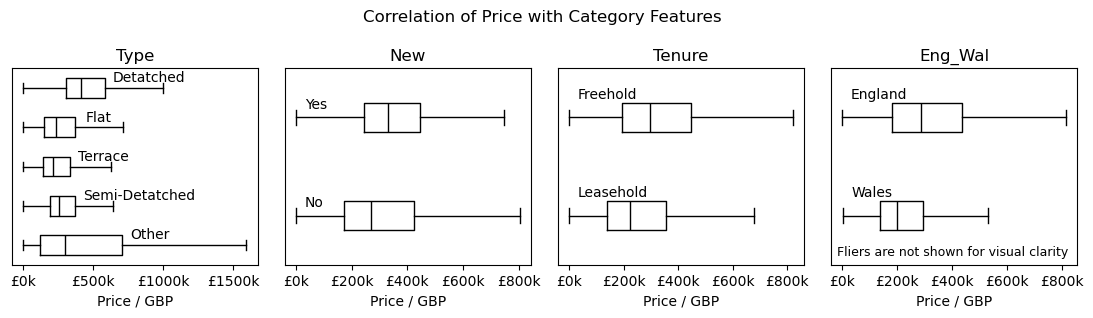

In [46]:
#Plotting correlation as boxplots for category features

#Arranging data for plotting
Eng_Wal_E = df[df['Eng_Wal']=='England']['Price']
Eng_Wal_W = df[df['Eng_Wal']=='Wales']['Price']

tenure_F = df[df['Tenure']=='F']['Price']
tenure_L = df[df['Tenure']=='L']['Price']

New_Y = df[df['New']=='Y']['Price']
New_N = df[df['New']=='N']['Price']

Type_D = df[df['Type']=='D']['Price']
Type_S = df[df['Type']=='S']['Price']
Type_T = df[df['Type']=='T']['Price']
Type_F = df[df['Type']=='F']['Price']
Type_O = df[df['Type']=='O']['Price']

#Plotting figure
fig, axs = plt.subplots(1,4)
fig.set_size_inches(11, 3.2)

axs[0].boxplot([Type_O, Type_S, Type_T, Type_F, Type_D], orientation='horizontal', showfliers=False, widths=0.5, medianprops={'color':'black'})
axs[0].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
axs[0].set_title('Type')
axs[0].tick_params(axis='y', length=0)
axs[0].set_xlabel('Price / GBP')
axs[0].set_yticks([1.3,2.3,3.3,4.3,5.3])
labels = axs[0].set_yticklabels(['Other','Semi-Detatched','Terrace','Flat','Detatched'])
label_offsets=[0.5,0.31,0.29,0.32,0.43]
for label,offset in zip(labels,label_offsets):
    label.set_x(offset)
    label.set_horizontalalignment('left')

axs[1].boxplot([New_N,New_Y], orientation='horizontal', showfliers=False, widths=0.3, medianprops={'color':'black'})
axs[1].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
axs[1].set_yticks([])
axs[1].set_title('New')
axs[1].tick_params(axis='y', length=0)
axs[1].set_xlabel('Price / GBP')
axs[1].set_yticks([1.15,2.15])
labels = axs[1].set_yticklabels(['No','Yes'])
for label in labels:
    label.set_x(0.1)
    label.set_horizontalalignment('left')

axs[2].boxplot([tenure_L,tenure_F], orientation='horizontal', showfliers=False, widths=0.3, medianprops={'color':'black'})
axs[2].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
axs[2].set_yticks([])
axs[2].set_title('Tenure')
axs[2].tick_params(axis='y', length=0)
axs[2].set_xlabel('Price / GBP')
axs[2].set_yticks([1.25,2.25])
labels = axs[2].set_yticklabels(['Leasehold','Freehold'])
for label in labels:
    label.set_x(0.1)
    label.set_horizontalalignment('left')

axs[3].boxplot([Eng_Wal_W,Eng_Wal_E], orientation='horizontal', showfliers=False, widths=0.3, medianprops={'color':'black'})
axs[3].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
axs[3].set_yticks([])
axs[3].set_yticks([1.25,2.25])
axs[3].set_title('Eng_Wal')
axs[3].tick_params(axis='y', length=0)
axs[3].set_xlabel('Price / GBP')
labels = axs[3].set_yticklabels(['Wales','England'])
for label in labels:
    label.set_x(0.1)
    label.set_horizontalalignment('left')



plt.suptitle('Correlation of Price with Category Features')
fig.tight_layout()

axs[3].text(-20000,0.6, 'Fliers are not shown for visual clarity', fontsize=9)

plt.savefig('figures//05_cat_features_cor.png', dpi = 600)
plt.show()

In [246]:
#Mapping categorical features into numbers

#Dummy variables for Type
#Dropping Other column
type_dummies = pd.get_dummies(df['Type'], prefix = 'Type', dtype=int)
type_dummies.drop('Type_O', axis=1, inplace=True)

df_numeric = df.join(type_dummies)
df_numeric.drop('Type', axis=1, inplace=True)
df_numeric['New'] = df_numeric['New'].map({'Y':1, 'N':0})
df_numeric['Tenure'] = df_numeric['Tenure'].map({'F':1, 'L':0})
df_numeric['Eng_Wal'] = df_numeric['Eng_Wal'].map({'England':1, 'Wales':0})

df_numeric.info(show_counts=True)
#All numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2832894 entries, 0 to 2832893
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Price                2832894 non-null  int64  
 1   New                  2832894 non-null  int64  
 2   Tenure               2832894 non-null  int64  
 3   latitude             2832894 non-null  float64
 4   longitude            2832894 non-null  float64
 5   gender_ratio         2832894 non-null  float64
 6   child_ratio          2832894 non-null  float64
 7   elderly_ratio        2832894 non-null  float64
 8   commute_distance     2832894 non-null  float64
 9   Income               2832894 non-null  float64
 10  Eng_Wal              2832894 non-null  int64  
 11  London_distance      2832894 non-null  float64
 12  listings_per_capita  2832894 non-null  float64
 13  days_since_first     2832894 non-null  int64  
 14  sine_day             2832894 non-null  float64
 15

In [247]:
correlation_matrix = df_numeric.corr()
correlation_matrix
#Copy this to excel and do more looking

,Price,New,Tenure,latitude,longitude,gender_ratio,child_ratio,elderly_ratio,commute_distance,Income,Eng_Wal,London_distance,listings_per_capita,days_since_first,sine_day,cosine_day,Type_D,Type_F,Type_S,Type_T
Price,1.000000,-0.003567,0.021530,-0.075633,0.059499,-0.002616,-0.035681,-0.013210,-0.032470,0.130573,0.023279,-0.104079,0.008633,-0.004960,-0.000991,-0.002996,0.039216,-0.023554,-0.036247,-0.046530
New,-0.003567,1.000000,-0.018081,0.024192,0.027374,0.045636,0.025921,-0.072915,0.056048,0.048393,0.034268,-0.006644,0.479125,-0.036553,0.016640,-0.005102,0.123652,0.064213,-0.011956,-0.128134
Tenure,0.021530,-0.018081,1.000000,0.086327,-0.073485,-0.052313,0.125753,0.200634,0.251472,-0.134101,-0.070989,0.148508,-0.092721,0.022729,-0.013143,-0.006565,0.266759,-0.826539,0.247515,0.215434
latitude,-0.075633,0.024192,0.086327,1.000000,-0.173378,0.072768,0.002954,0.035951,-0.110573,-0.445410,0.073296,0.717287,0.065811,0.007716,0.005396,-0.000463,0.004053,-0.178684,0.096182,0.060772
longitude,0.059499,0.027374,-0.073485,-0.173378,1.000000,-0.040510,0.069257,-0.132892,0.068306,0.419990,0.387599,-0.681684,-0.008698,-0.003110,-0.003814,-0.002694,-0.020018,0.141647,-0.043387,-0.051644
gender_ratio,-0.002616,0.045636,-0.052313,0.072768,-0.040510,1.000000,-0.140750,-0.245609,-0.038584,-0.080711,-0.002914,0.054636,0.134573,-0.006919,0.007940,0.000631,-0.028376,0.049083,-0.049090,0.011431
child_ratio,-0.035681,0.025921,0.125753,0.002954,0.069257,-0.140750,1.000000,-0.468628,-0.046675,0.041676,0.026950,-0.100498,-0.154979,-0.004752,0.004533,0.003863,-0.052769,-0.152235,0.075858,0.136060
elderly_ratio,-0.013210,-0.072915,0.200634,0.035951,-0.132892,-0.245609,-0.468628,1.000000,0.362911,-0.153708,-0.059171,0.223584,-0.079951,0.014772,-0.010248,-0.002137,0.251313,-0.204906,0.086661,-0.147220
commute_distance,-0.032470,0.056048,0.251472,-0.110573,0.068306,-0.038584,-0.046675,0.362911,1.000000,-0.062002,-0.126542,0.007877,0.035677,-0.001097,-0.004038,-0.000119,0.222166,-0.204583,0.026853,-0.067481
Income,0.130573,0.048393,-0.134101,-0.445410,0.419990,-0.080711,0.041676,-0.153708,-0.062002,1.000000,0.167750,-0.663746,0.035456,0.000509,-0.014576,-0.009493,0.040930,0.204915,-0.072932,-0.134650


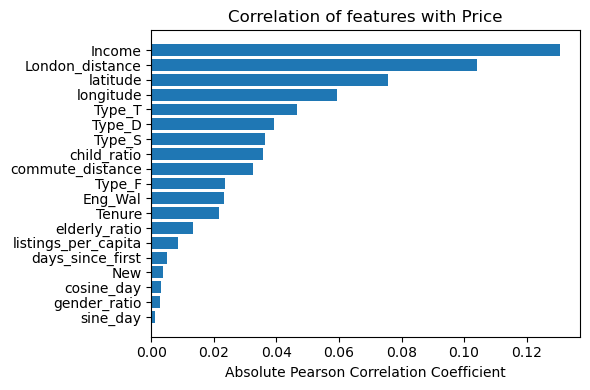

In [271]:
#Importance based on correlation with price
price_corr = correlation_matrix['Price']
price_corr.drop('Price', axis=0, inplace=True)
price_corr = price_corr.abs()
price_corr.sort_values(inplace=True)

plt.figure(figsize=(6, 4))
plt.barh(price_corr.index, price_corr.values)
plt.title('Correlation of features with Price')
plt.xlabel('Absolute Pearson Correlation Coefficient')
plt.tight_layout()
plt.savefig('figures//06_corr_bar.png', dpi=600)
plt.show()

E. Feature covariance

In [273]:
X = df_numeric.drop('Price', axis=1)

In [274]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data

,feature,VIF
0,New,1.523216
1,Tenure,13.861865
2,latitude,865.751883
3,longitude,4.811281
4,gender_ratio,584.026719
5,child_ratio,25.867620
6,elderly_ratio,10.874985
7,commute_distance,30.041127
8,Income,30.966595
9,Eng_Wal,24.515961


In [275]:
#Same as previous, but dropping gender ratio
X_2 = X.drop('gender_ratio', axis=1)

vif_data_2 = pd.DataFrame()
vif_data_2['feature'] = X_2.columns

vif_data_2["VIF_dropped_gender"] = [variance_inflation_factor(X_2.values, i)
                          for i in range(len(X_2.columns))]

In [276]:
#Same as previous, but dropping gender ratio
X_2 = X.drop('gender_ratio', axis=1)

vif_data_2 = pd.DataFrame()
vif_data_2['feature'] = X_2.columns

vif_data_2["VIF_dropped_gender"] = [variance_inflation_factor(X_2.values, i)
                          for i in range(len(X_2.columns))]

In [277]:
#Now dropping latitude (keeping gender ratio
X_3 = X.drop('latitude', axis=1)

vif_data_3 = pd.DataFrame()
vif_data_3['feature'] = X_3.columns

vif_data_3["VIF_dropped_latitude"] = [variance_inflation_factor(X_3.values, i)
                          for i in range(len(X_3.columns))]

In [278]:
#Dropping both gender ratio and latitude
X_4 = X.drop(['latitude','gender_ratio'], axis=1)

vif_data_4 = pd.DataFrame()
vif_data_4['feature'] = X_4.columns

vif_data_4["VIF_dropped_gender_and_latitude"] = [variance_inflation_factor(X_4.values, i)
                          for i in range(len(X_4.columns))]

In [279]:
vif_data.sort_values(by='VIF', ascending=True, inplace=True)
vif_data

,feature,VIF
14,cosine_day,1.001291
13,sine_day,1.090009
0,New,1.523216
11,listings_per_capita,3.586760
12,days_since_first,4.043136
3,longitude,4.811281
15,Type_D,5.233051
17,Type_S,5.894444
18,Type_T,5.925259
16,Type_F,6.437725


In [280]:
vif_data.join(
    vif_data_2.set_index('feature'), on='feature').join(
    vif_data_3.set_index('feature'), on='feature').join(
    vif_data_4.set_index('feature'), on='feature')

,feature,VIF,VIF_dropped_gender,VIF_dropped_latitude,VIF_dropped_gender_and_latitude
14,cosine_day,1.001291,1.001290,1.001290,1.001290
13,sine_day,1.090009,1.089989,1.089793,1.088197
0,New,1.523216,1.522786,1.522227,1.509894
11,listings_per_capita,3.586760,3.578971,3.586078,3.521902
12,days_since_first,4.043136,4.043124,4.031092,3.977635
3,longitude,4.811281,4.496624,4.611684,4.480074
15,Type_D,5.233051,5.232972,5.209684,5.099885
17,Type_S,5.894444,5.892482,5.818273,5.605378
18,Type_T,5.925259,5.923298,5.816306,5.489634
16,Type_F,6.437725,6.437670,6.210671,5.301792


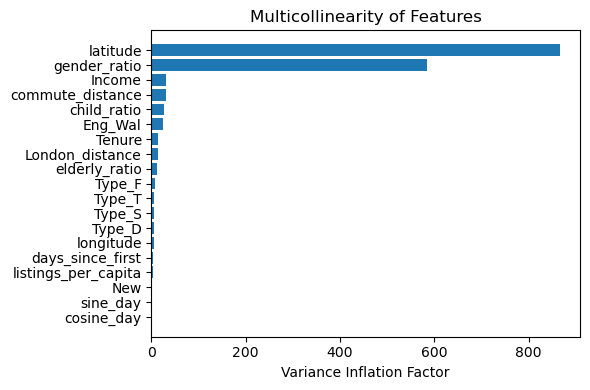

In [282]:
plt.figure(figsize=(6, 4))
plt.barh(vif_data['feature'], vif_data['VIF'])
plt.title('Multicollinearity of Features')
plt.xlabel('Variance Inflation Factor')
plt.tight_layout()
plt.savefig('figures//07_vif.png', dpi=600)
plt.show()